# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lib_file import lib_path
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Data Loading

In [2]:
base_dir='input'
class_labels=os.listdir(base_dir)
class_labels.sort()
print(class_labels)

['covid', 'normal']


In [3]:
chart_data=[]
for target in class_labels:
    path=os.path.join(base_dir,target)
    size=len(os.listdir(path))
    chart_data.append(size)
    print(f'The target {target} has ({size}) samples in the dataset')

The target covid has (1000) samples in the dataset
The target normal has (1000) samples in the dataset


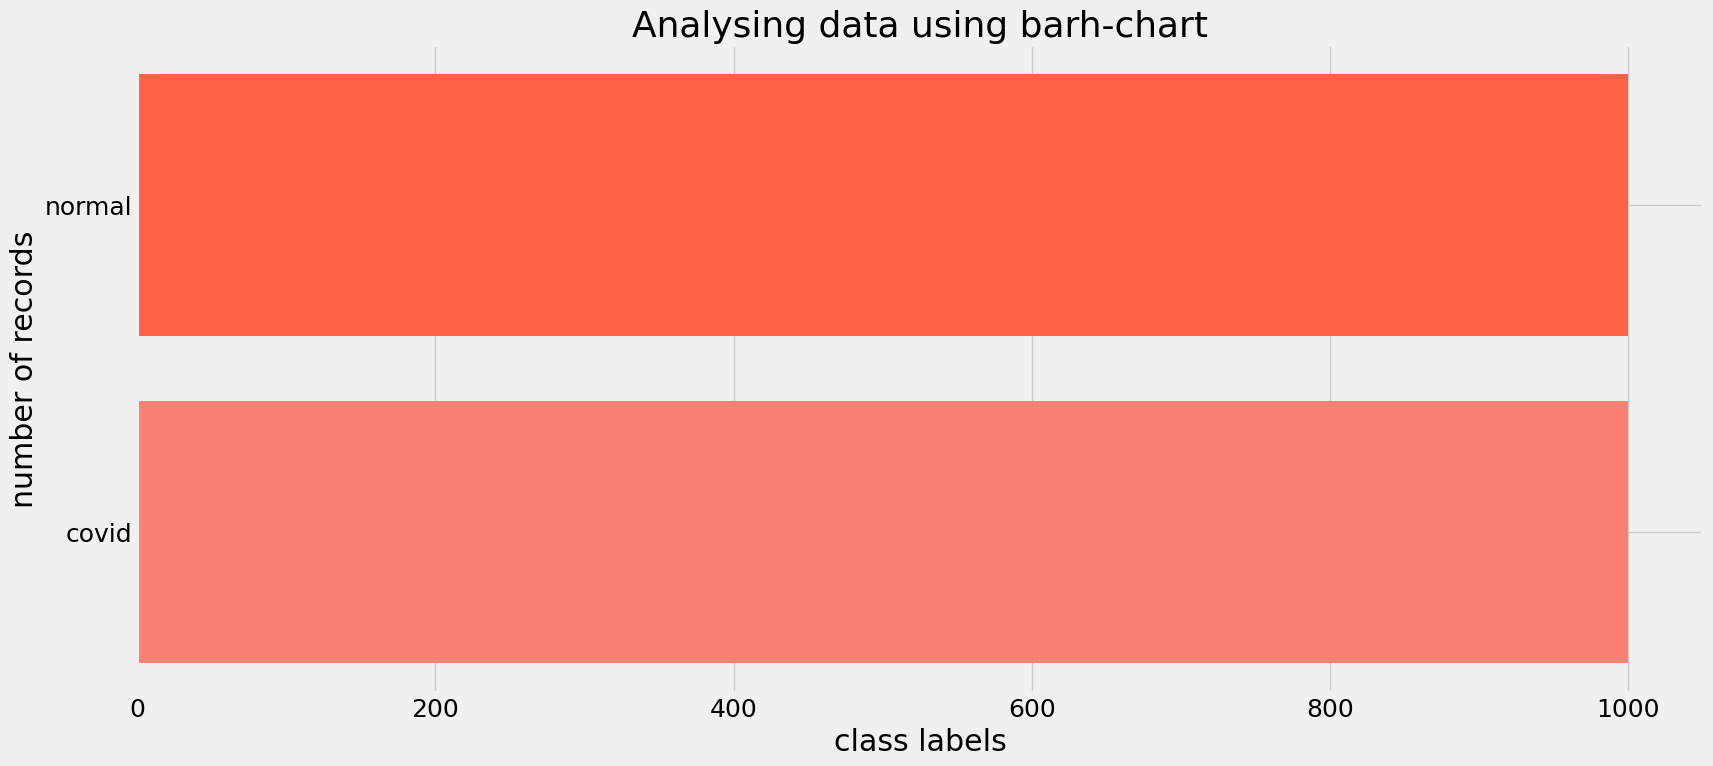

In [4]:
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(18,8))
    plt.rcParams["font.size"]=18
    plt.barh(y=class_labels,
             width=chart_data,
             color=["salmon","tomato","darksalmon"])
    plt.title(label="Analysing data using barh-chart")
    plt.xlabel(xlabel="class labels")
    plt.ylabel(ylabel="number of records")
    plt.show()

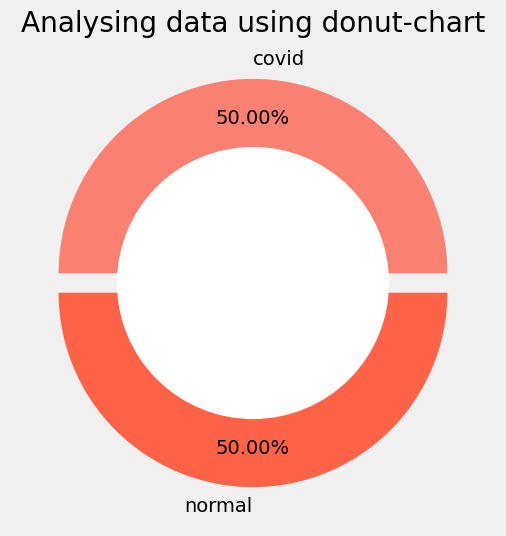

In [5]:
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(6,6))
    plt.pie(x=chart_data,
        colors=["salmon","tomato","darksalmon"],
        labels=class_labels,
        autopct='%.2f%%',
        pctdistance=0.80,
        explode=[0.05]*len(class_labels))
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title(label="Analysing data using donut-chart")
    plt.show()

In [6]:
data=[]
labels=[]
count=0
for target in class_labels:
    path=os.path.join(base_dir,target)
    print(f'Images loading from {path}')
    image_names=os.listdir(path)
    for image_name in tqdm(image_names):
        image_path=os.path.join(path,image_name)
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(128,128))
        image=np.array(image)
        image=image/255.0
        data.append(image)
        labels.append(count)
    count+=1

Images loading from input\covid


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.60it/s]


Images loading from input\normal


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.12it/s]


In [7]:
data=np.array(data)
labels=np.array(labels)

print(data.shape,labels.shape)

(2000, 128, 128, 3) (2000,)


In [8]:
from random import randint
def show_images(X,y,class_names):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        idx = randint(0, X.shape[0]-1)
        plt.imshow(X[idx])
        plt.axis("off")
        plt.title("Class:{}".format(class_names[y[idx]]))
    plt.tight_layout()
    plt.show()

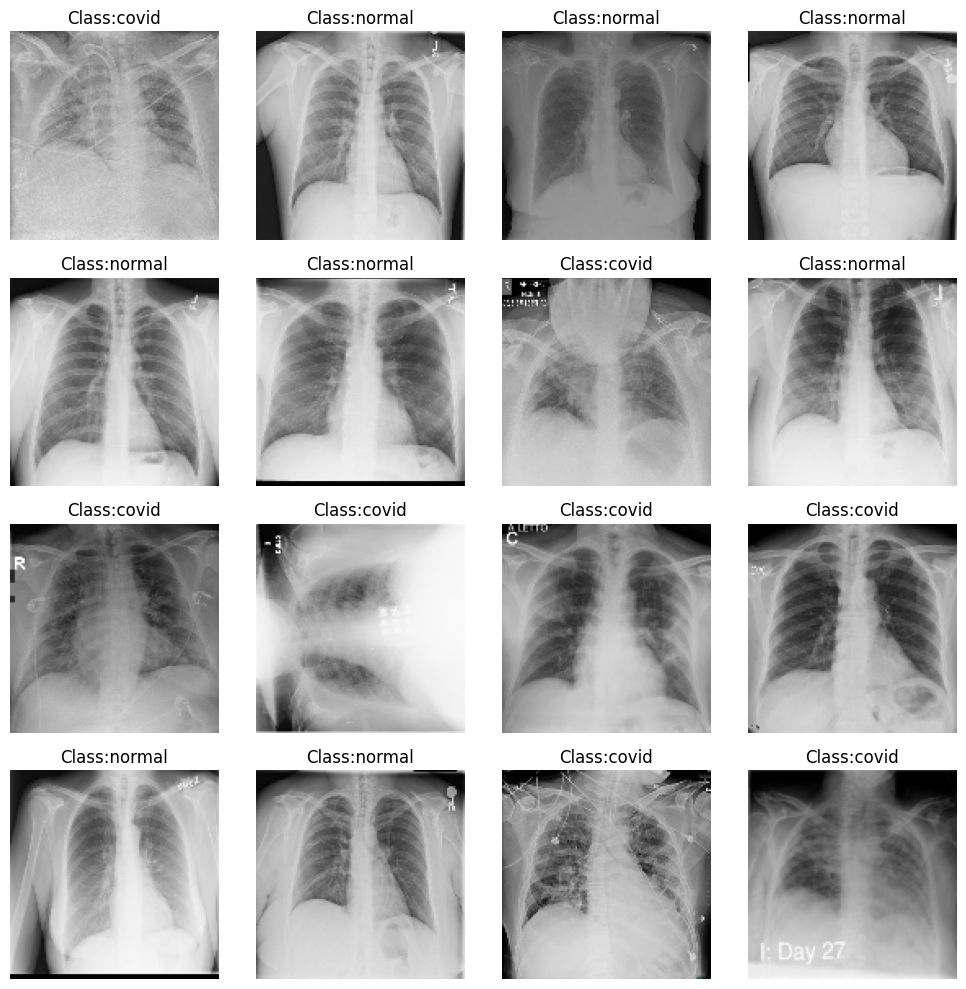

In [9]:
show_images(data,labels,class_labels)

In [10]:
y=to_categorical(labels)
X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.2,random_state=42,shuffle=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1600, 128, 128, 3) (400, 128, 128, 3) (1600, 2) (400, 2)


In [11]:
densenet_model=tf.keras.applications.DenseNet201(include_top=False,
                                                   weights="imagenet",
                                                   input_tensor=None,
                                                   input_shape=(128,128,3),
                                                   pooling="max",
                                                   classes=1000)
densenet_model.trainable = False

In [12]:
inputs = densenet_model.input
fc1=tf.keras.layers.Dense(512, activation='relu')(densenet_model.output)
fc2=tf.keras.layers.Dense(len(class_labels), activation='softmax')(fc1)
dense_model = tf.keras.Model(inputs=inputs, outputs=fc2)

In [13]:
dense_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
dense_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_block11_concat (Concaten  (None, 4, 4, 1248)  0           ['conv5_block10_concat[0][0]',   
 ate)     

 conv5_block15_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 4, 4, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 4, 4, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 4, 4, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block20_0_relu (Activati  (None, 4, 4, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 4, 4, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block20_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 4, 4, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block28_concat (Concaten  (None, 4, 4, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 4, 4, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 4, 4, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block29_1_conv (Conv2D)  (None, 4, 4, 128)    229376      ['conv5_block29_0_relu[0][0]']   
          

 max_pool (GlobalMaxPooling2D)  (None, 1920)         0           ['relu[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 512)          983552      ['max_pool[0][0]']               
                                                                                                  
 dense_1 (Dense)                (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
Total params: 19,306,562
Trainable params: 984,578
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [15]:
number_of_epochs=30
history=dense_model.fit(x=X_train,y=y_train,batch_size=32,epochs=number_of_epochs,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/30
50/50 [==============================] - 395s 6s/step - loss: 1.2905 - accuracy: 0.7600 - val_loss: 0.2600 - val_accuracy: 0.9050
Epoch 2/30
50/50 [==============================] - 240s 5s/step - loss: 0.1918 - accuracy: 0.9250 - val_loss: 0.1743 - val_accuracy: 0.9300
Epoch 3/30
50/50 [==============================] - 251s 5s/step - loss: 0.1204 - accuracy: 0.9575 - val_loss: 0.1743 - val_accuracy: 0.9325
Epoch 4/30
50/50 [==============================] - 250s 5s/step - loss: 0.0966 - accuracy: 0.9675 - val_loss: 0.1565 - val_accuracy: 0.9450
Epoch 5/30
50/50 [==============================] - 255s 5s/step - loss: 0.0696 - accuracy: 0.9750 - val_loss: 0.1375 - val_accuracy: 0.9475
Epoch 6/30
50/50 [==============================] - 242s 5s/step - loss: 0.0482 - accuracy: 0.9869 - val_loss: 0.1464 - val_accuracy: 0.9500
Epoch 7/30
50/50 [==============================] - 226s 5s/step - loss: 0.0390 - accuracy: 0.9912 - val_loss: 0.1465 - val_accuracy: 0.9525
Epoch 8/30
50

### Accuracy and Loss plot-graphs

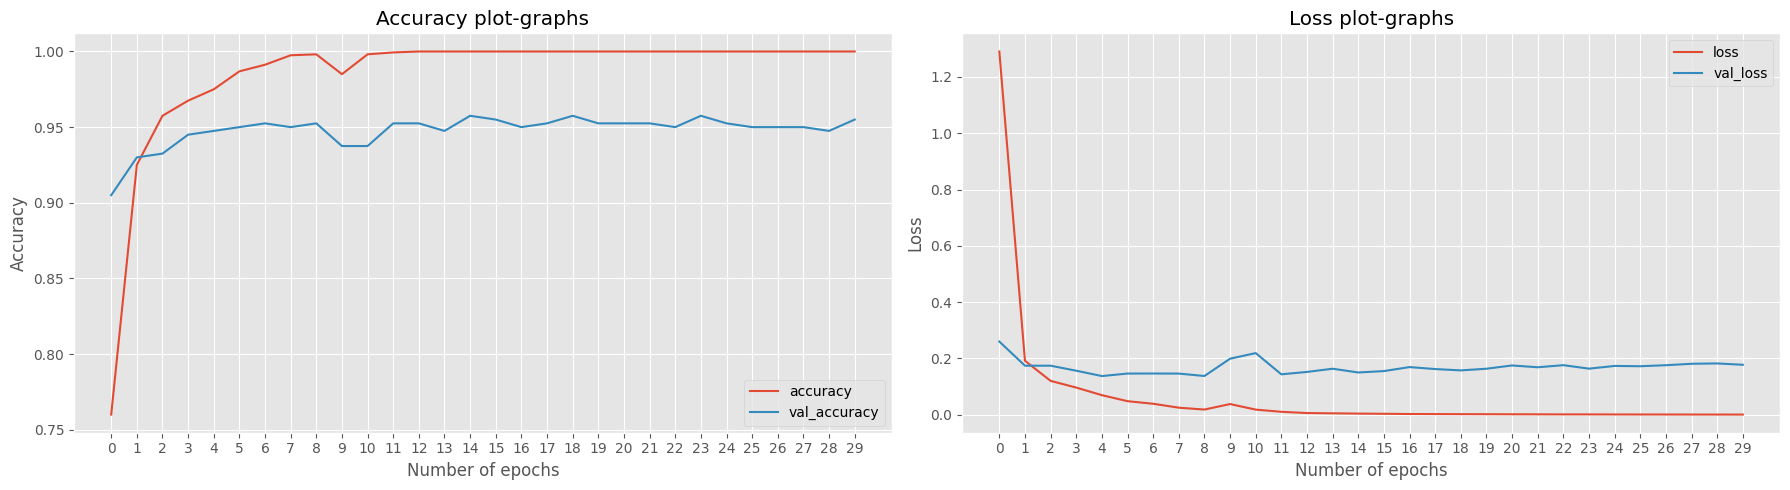

In [16]:
with plt.style.context(style='ggplot'):
    fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    axes[0].plot(history.history["accuracy"],label="accuracy")
    axes[0].plot(history.history["val_accuracy"],label="val_accuracy")
    axes[0].set_title(label='Accuracy plot-graphs')
    axes[0].set_xlabel(xlabel='Number of epochs')
    axes[0].set_ylabel(ylabel='Accuracy')
    axes[0].set_xticks(range(number_of_epochs))
    axes[0].legend()
    axes[1].plot(history.history["loss"],label="loss")
    axes[1].plot(history.history["val_loss"],label="val_loss")
    axes[1].set_title(label='Loss plot-graphs')
    axes[1].set_xlabel(xlabel='Number of epochs')
    axes[1].set_ylabel(ylabel='Loss')
    axes[1].set_xticks(range(number_of_epochs))
    axes[1].legend()
    fig.tight_layout()
    plt.show()

In [17]:
dense_model_prediction=dense_model.predict(X_test,batch_size=32,verbose=1)

13/13 [==============================] - 73s 3s/step


In [18]:
print(dense_model_prediction)

[[8.28568998e-04 9.99171495e-01]
 [3.09644165e-05 9.99969006e-01]
 [3.22785922e-06 9.99996781e-01]
 [9.92111683e-01 7.88828917e-03]
 [4.54211673e-08 1.00000000e+00]
 [1.18634598e-04 9.99881387e-01]
 [1.00000000e+00 3.60714587e-08]
 [1.38062182e-06 9.99998569e-01]
 [9.97115016e-01 2.88495887e-03]
 [4.49391920e-03 9.95506048e-01]
 [9.99995828e-01 4.22140420e-06]
 [2.97368956e-06 9.99997020e-01]
 [3.38015343e-05 9.99966145e-01]
 [9.99999642e-01 3.37978946e-07]
 [9.99894023e-01 1.06003979e-04]
 [9.99683857e-01 3.16211372e-04]
 [1.00000000e+00 6.82125580e-12]
 [7.87557542e-01 2.12442428e-01]
 [1.62439142e-06 9.99998331e-01]
 [3.18123550e-09 1.00000000e+00]
 [1.00000000e+00 5.88951714e-08]
 [3.89348678e-02 9.61065114e-01]
 [9.36722875e-01 6.32771105e-02]
 [1.33833368e-04 9.99866128e-01]
 [1.44147734e-07 9.99999881e-01]
 [9.96094882e-01 3.90509982e-03]
 [7.46954174e-06 9.99992490e-01]
 [9.93117690e-01 6.88234670e-03]
 [9.98275995e-01 1.72401266e-03]
 [1.00000000e+00 7.81052389e-10]
 [1.000000

In [19]:
dense_model_pred=[]
for i in range(len(dense_model_prediction)):
    dense_model_pred.append(np.argmax(dense_model_prediction[i]))

In [20]:
print(dense_model_pred)

[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 

In [21]:
true_labels=[]
for i in range(len(y_test)):
    true_labels.append(np.argmax(y_test[i]))

In [22]:
print(true_labels)

[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 

### Result Analysis

***Accuracy Score***

In [23]:
densemodel_accuracy=accuracy_score(y_true=true_labels,y_pred=dense_model_pred)
print(f"Validation accuracy of DenseNet201 model accuracy is {densemodel_accuracy*100.0:.2f}%")

Validation accuracy of DenseNet201 model accuracy is 95.50%


***Classification Report***

In [24]:
from IPython.core.display import display,HTML
display(HTML("<h1>DenseNet201 model classification report"))
print(classification_report(y_true=true_labels,y_pred=dense_model_pred,target_names=class_labels))

              precision    recall  f1-score   support

       covid       0.96      0.94      0.95       199
      normal       0.95      0.97      0.96       201

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400



***Confusion Matrix***

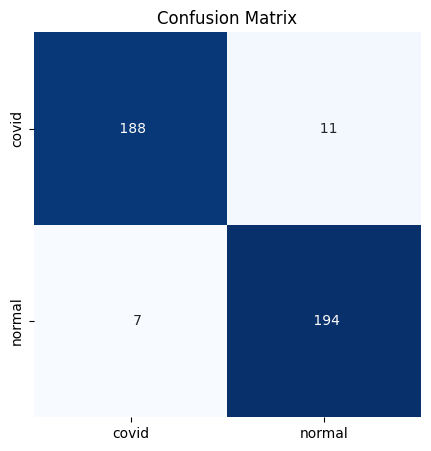

In [25]:
plt.figure(figsize=(5,5))
sns.heatmap(data=confusion_matrix(y_true=true_labels,y_pred=dense_model_pred),
            annot=True,
            fmt='4d',
            cbar=False,
            cmap=plt.cm.Blues,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title(label='Confusion Matrix')
plt.show()

***Model Saving***

In [26]:
dense_model.save(filepath="models/DenseNet201_model.h5")